In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform
import random
import keras
from keras.datasets import mnist

# 1 A:

In [2]:
(x_trian, y_trian), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
def show_digits():
    """The method find a digit and plot it """
    plt.figure(figsize=[10, 20])
    for i in range(10):
        k = np.where(y_trian == i) 
        index = int(k[0][0])
        plt.subplot(1,10,i+1)
        plt.imshow(x_trian[index], cmap='gray')
        plt.title(f'Digit: {i}')
    plt.show()

def to_dictionary():
    """Arange all the digits in a format of a dictionary,
     each key represente a title of number between 0 to 9.
     The function save for each digit group a list of tuples,for דhorten computational time it save indexes insted of real images"""
    dic ={}
    for i in range(10):
        dic[i] = np.where(y_trian == i)[0]
    return dic

def get_ingredients(num):
    '''The function check if number needed to add zeros for get uniform shape of persention '''
    if(num <= 100):
        if num < 10:
            str_num = '00' + str(num)
        if num > 9 and num < 100 :
            str_num = '0' + str(num)
        if num == 100:
            str_num = str(num)
    return [int(d) for d in str_num]

def generate_full_dictionary(basic_dic, amount = 6000):
    '''The function generate random numbers from the basic dictionary. 
        For lower computational the function save indexes and won't acutally create images'''
    full_dic={}
    for i in range(101):
        temp = []
        for j in range(amount):
            l = get_ingredients(i)
            digit1, digit2, digit3 = l[:3]
            index1 = np.random.choice(basic_dic.get(digit1))
            index2 = np.random.choice(basic_dic.get(digit2))
            index3 = np.random.choice(basic_dic.get(digit3))
            temp.append([index1, index2, index3])

        full_dic[i] = temp

    return full_dic
      
def generate_image(images_indexes_list): 
    '''The function create image'''
    l = [x_trian[int(index)] for index in images_indexes_list ]
    return cv2.hconcat(l)
def norm(img):
    """The function scale the image for a value between 0-1"""
    img = np.asanyarray(img, 'float32')
    img -= img.min()
    img /= img.max()
    return img

def sobel_edges_detection(img):
    sobelx = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=3)
    sobely = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=3)
    normx=norm(sobelx)
    normy=norm(sobely)
    sobel = cv2.sqrt(cv2.addWeighted(cv2.pow(normx, 2.0), 1.0, cv2.pow(normy, 2.0), 1.0, 0.0))
    return sobel

def canny_edges_detection(img, threshold1 = 1, threshold2 = 255):
    return cv2.Canny(img,threshold1, threshold2)

In [8]:
class augmentation(object):
    @staticmethod
    def Flip(img, axis):
        return cv2.flip(img,axis)

    @staticmethod
    def Rotate(img, degree, resize = False):
        '''Return: ndarray format '''
        return transform.rotate(img, degree, resize)
    
    @staticmethod   
    def ShiftingX(img, shift):# New
        rows,cols = img.shape[:2]
        M = np.float32([[1,0, shift],[0,1,0]])
        return cv2.warpAffine(img,M,(cols,rows))

    @staticmethod   
    def ShiftingY(img, shift): # New
        rows,cols = img.shape[:2]
        M = np.float32([[1, 0, 0], [0, 1, shift]])
        return cv2.warpAffine(img, M, (cols, rows))

    @staticmethod   
    def GaussianBlur(img, ksize,sigmaX):
        return cv2.GaussianBlur(img, ksize,sigmaX)
    
    @staticmethod   
    def MedianBlur(img, ksize):
        img = np.uint8(img)
        return cv2.medianBlur(img, ksize)
    @staticmethod   
    def averageingBlur(img,ksize): # New
        return cv2.blur(img,(ksize,ksize))

    @staticmethod   
    def bileteralBlur(img, d, sigmaColor, sigmaSpace): # New
        return cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)

    @staticmethod
    def solt_and_paper (img, s_vs_p, amount): # New
        row, col = img.shape[:2]
        noise = np.copy(img)
        # Salt mode
        num_salt = np.ceil(amount * img.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in img.shape]
        noise[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* img.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in img.shape]
        noise[coords] = 0
        return noise

    @staticmethod   
    def erosion_image(img,ksize):# New
        kernel = np.ones((ksize,ksize),np.uint8)
        return cv2.erode(img, kernel, iterations = 1)

    @staticmethod   
    def dilation_image(img,ksize):# New
        kernel = np.ones((ksize, ksize), np.uint8)
        return cv2.dilate(img,kernel,iterations = 1)
    
    @staticmethod   
    def opening_image(img,ksize): # New
        kernel = np.ones((ksize, ksize), np.uint8)
        return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    @staticmethod   
    def closing_image(img, ksize): # New 
        kernel = np.ones((ksize, ksize), np.uint8)
        return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    @staticmethod   
    def morphological_gradient_image(img, ksize): # New
        kernel = np.ones((ksize, ksize), np.uint8)
        return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)

    @staticmethod   
    def Zoom(img, position, zoom_scale):
        h,w=img.shape[:2]
        if zoom_scale < 0:
            zoom_scale = 1/abs(zoom_scale)
        if zoom_scale == 1:
            return img
        width = int(img.shape[1] * zoom_scale)
        height = int(img.shape[0] * zoom_scale)
        dim = (width, height)
        # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #crop
        half_height = h/2
        half_width = w/2

        position = [element * zoom_scale for element in position]

        start_crop_width = augmentation.cal_lenght(position[0], half_height, True)
        end_crop_width = augmentation.cal_lenght(position[0], half_height)

        strat_crop_height = augmentation.cal_lenght(position[1], half_height, True)
        end_crop_height = augmentation.cal_lenght(position[1], half_height)

        start_position = (start_crop_width, strat_crop_height)
        end_position = (end_crop_width, end_crop_height)

        croped = augmentation.Crop(resized, start_position, end_position)
        
        return croped
    
    @staticmethod   
    def Crop(img, start_position, end_position):
        start_position, end_position = augmentation.Check_boundary(img, start_position, end_position) 
        crop_img = img[start_position[0]:end_position[0], start_position[1]:end_position[1]]
        return crop_img
    

    @staticmethod   
    def Check_boundary (img, start_position, end_position):
        height, width  = img.shape[:2]
        s_y, s_x  = start_position
        e_y, e_x  = end_position
        
        s_x, e_x = min(s_x,e_x), max(s_x,e_x)
        s_y, e_y = min(s_y, e_y), max(s_y, e_y)

        s_x = augmentation.cal_boundary(s_x,width)
        e_x = augmentation.cal_boundary(e_x,width)

        s_y = augmentation.cal_boundary(s_y,height)
        e_y = augmentation.cal_boundary(e_y,height)
 
        
        start_position =int(s_y), int(s_x)
        end_position = int(e_y), int(e_x)   
        
        return start_position, end_position

    @staticmethod
    def cal_boundary(point, lim):
      if point < 0 or point > lim:
        if point < 0:
          point = 0
        else:
          point = lim - 1
      return point

    @staticmethod
    def cal_lenght (point, lenght, start_point = False):
        if start_point:
            lenght = (-1) * lenght
        return int(point + lenght)

# 1 B:

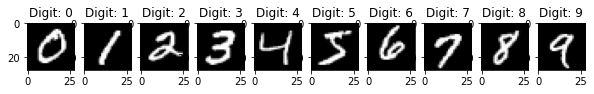

In [9]:
show_digits()

# 1 C, D:


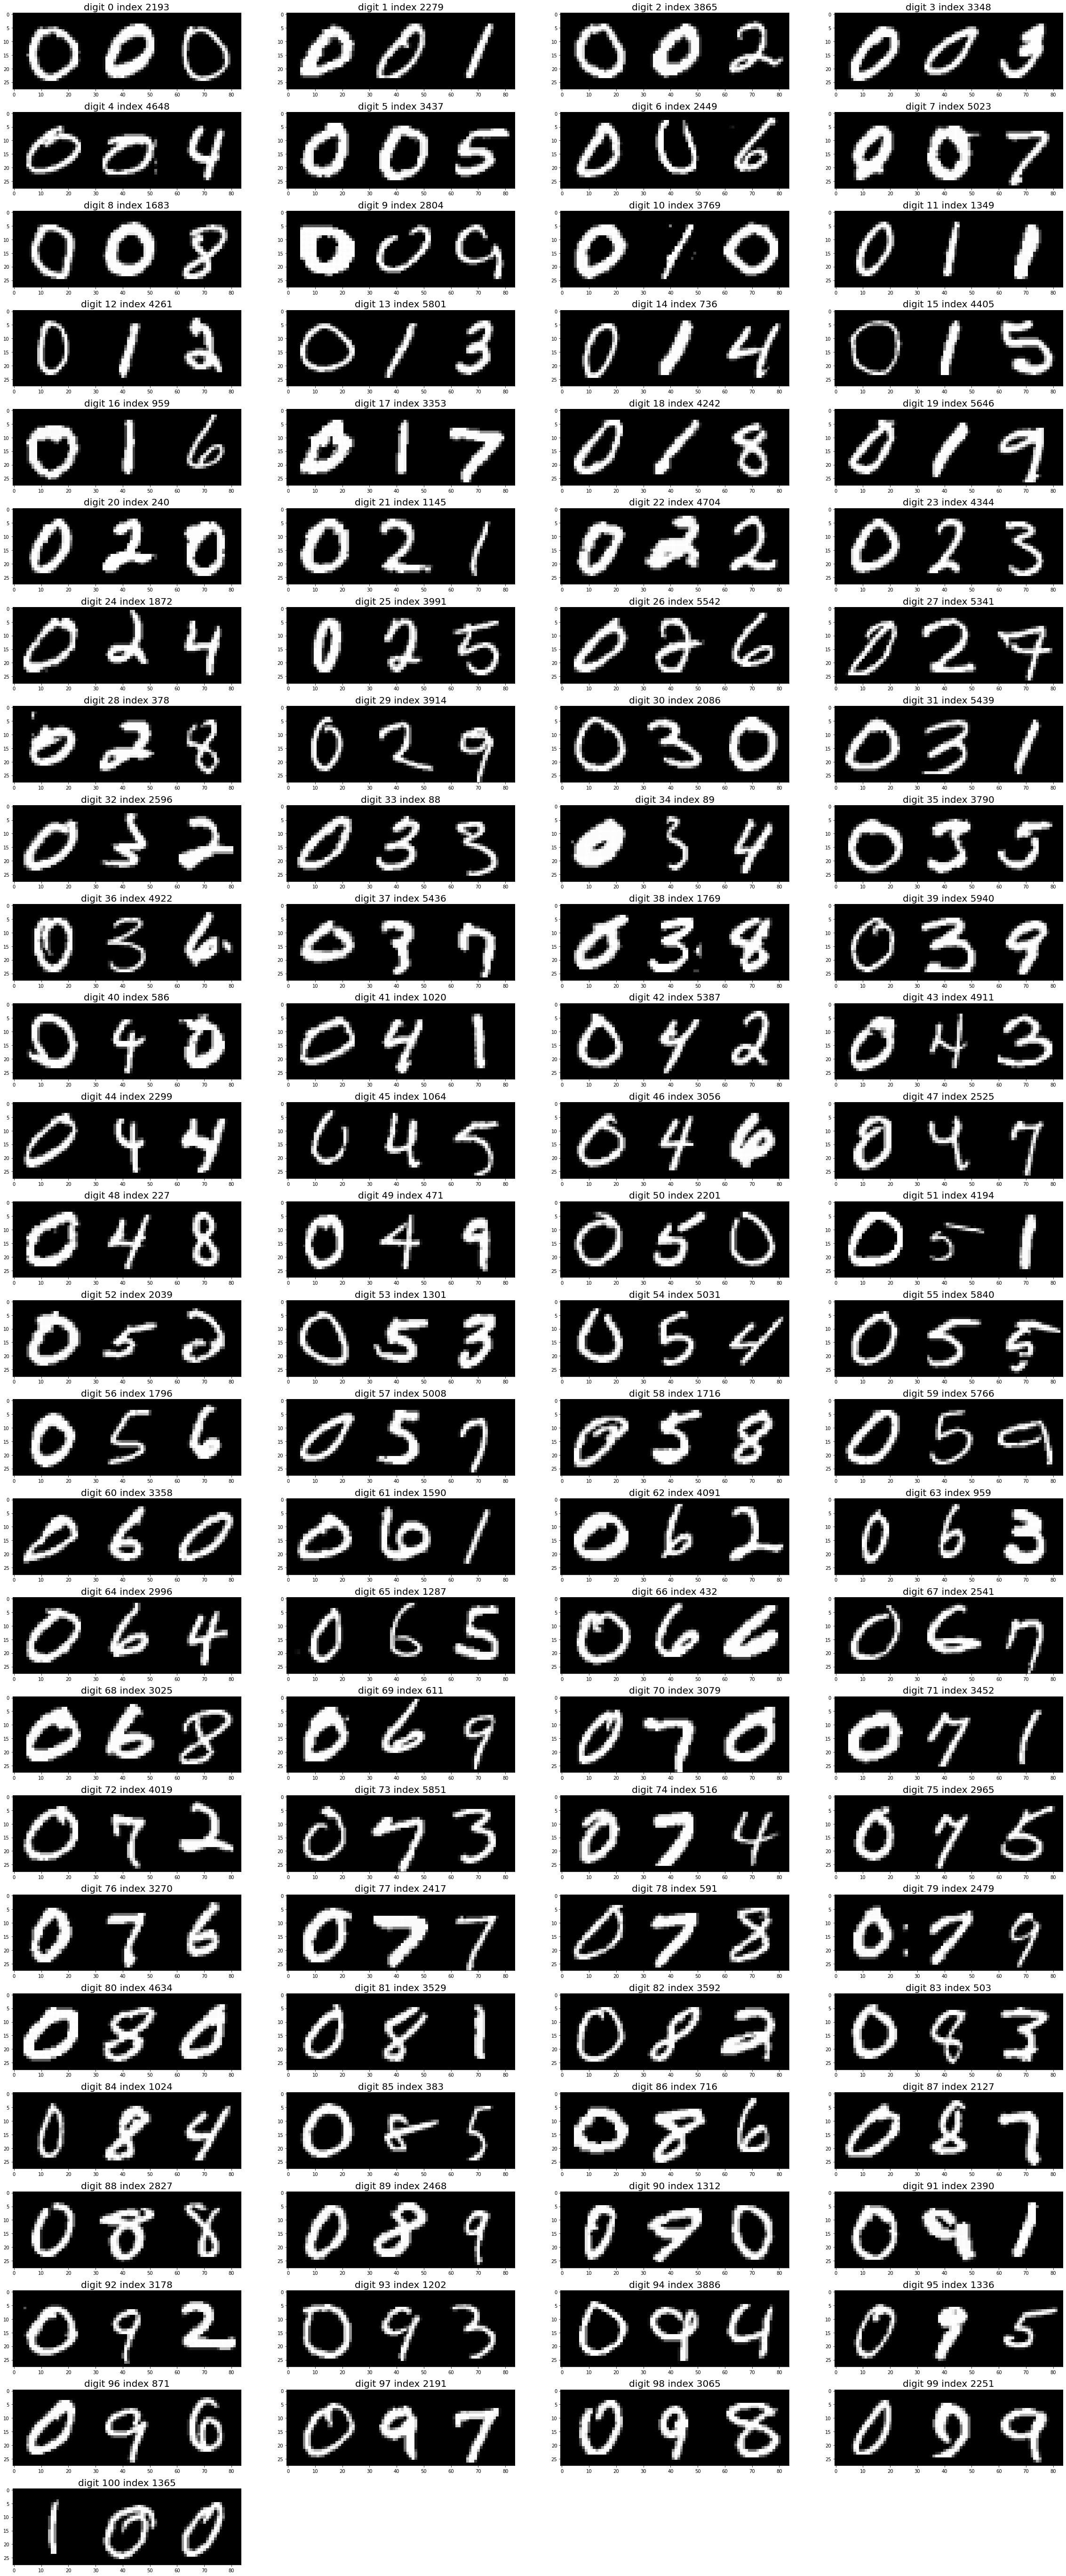

In [10]:
digit_dic = to_dictionary()
full_digit_dic = generate_full_dictionary(digit_dic)

all_images = []
all_titles = []
for i in range(101):
    index = np.random.randint(6000)
    img = generate_image(full_digit_dic.get(i)[index])
    tit = f'digit {i} index {index}'
    all_images.append(img)
    all_titles.append(tit)

plt.figure(figsize = (40, 100))

for i in range(len(all_images)):
    plt.subplot(26, 4, i+1)
    plt.imshow(all_images[i], cmap = plt.cm.gray)
    plt.title(all_titles[i], fontsize = 20)

plt.show()

# 1 E:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


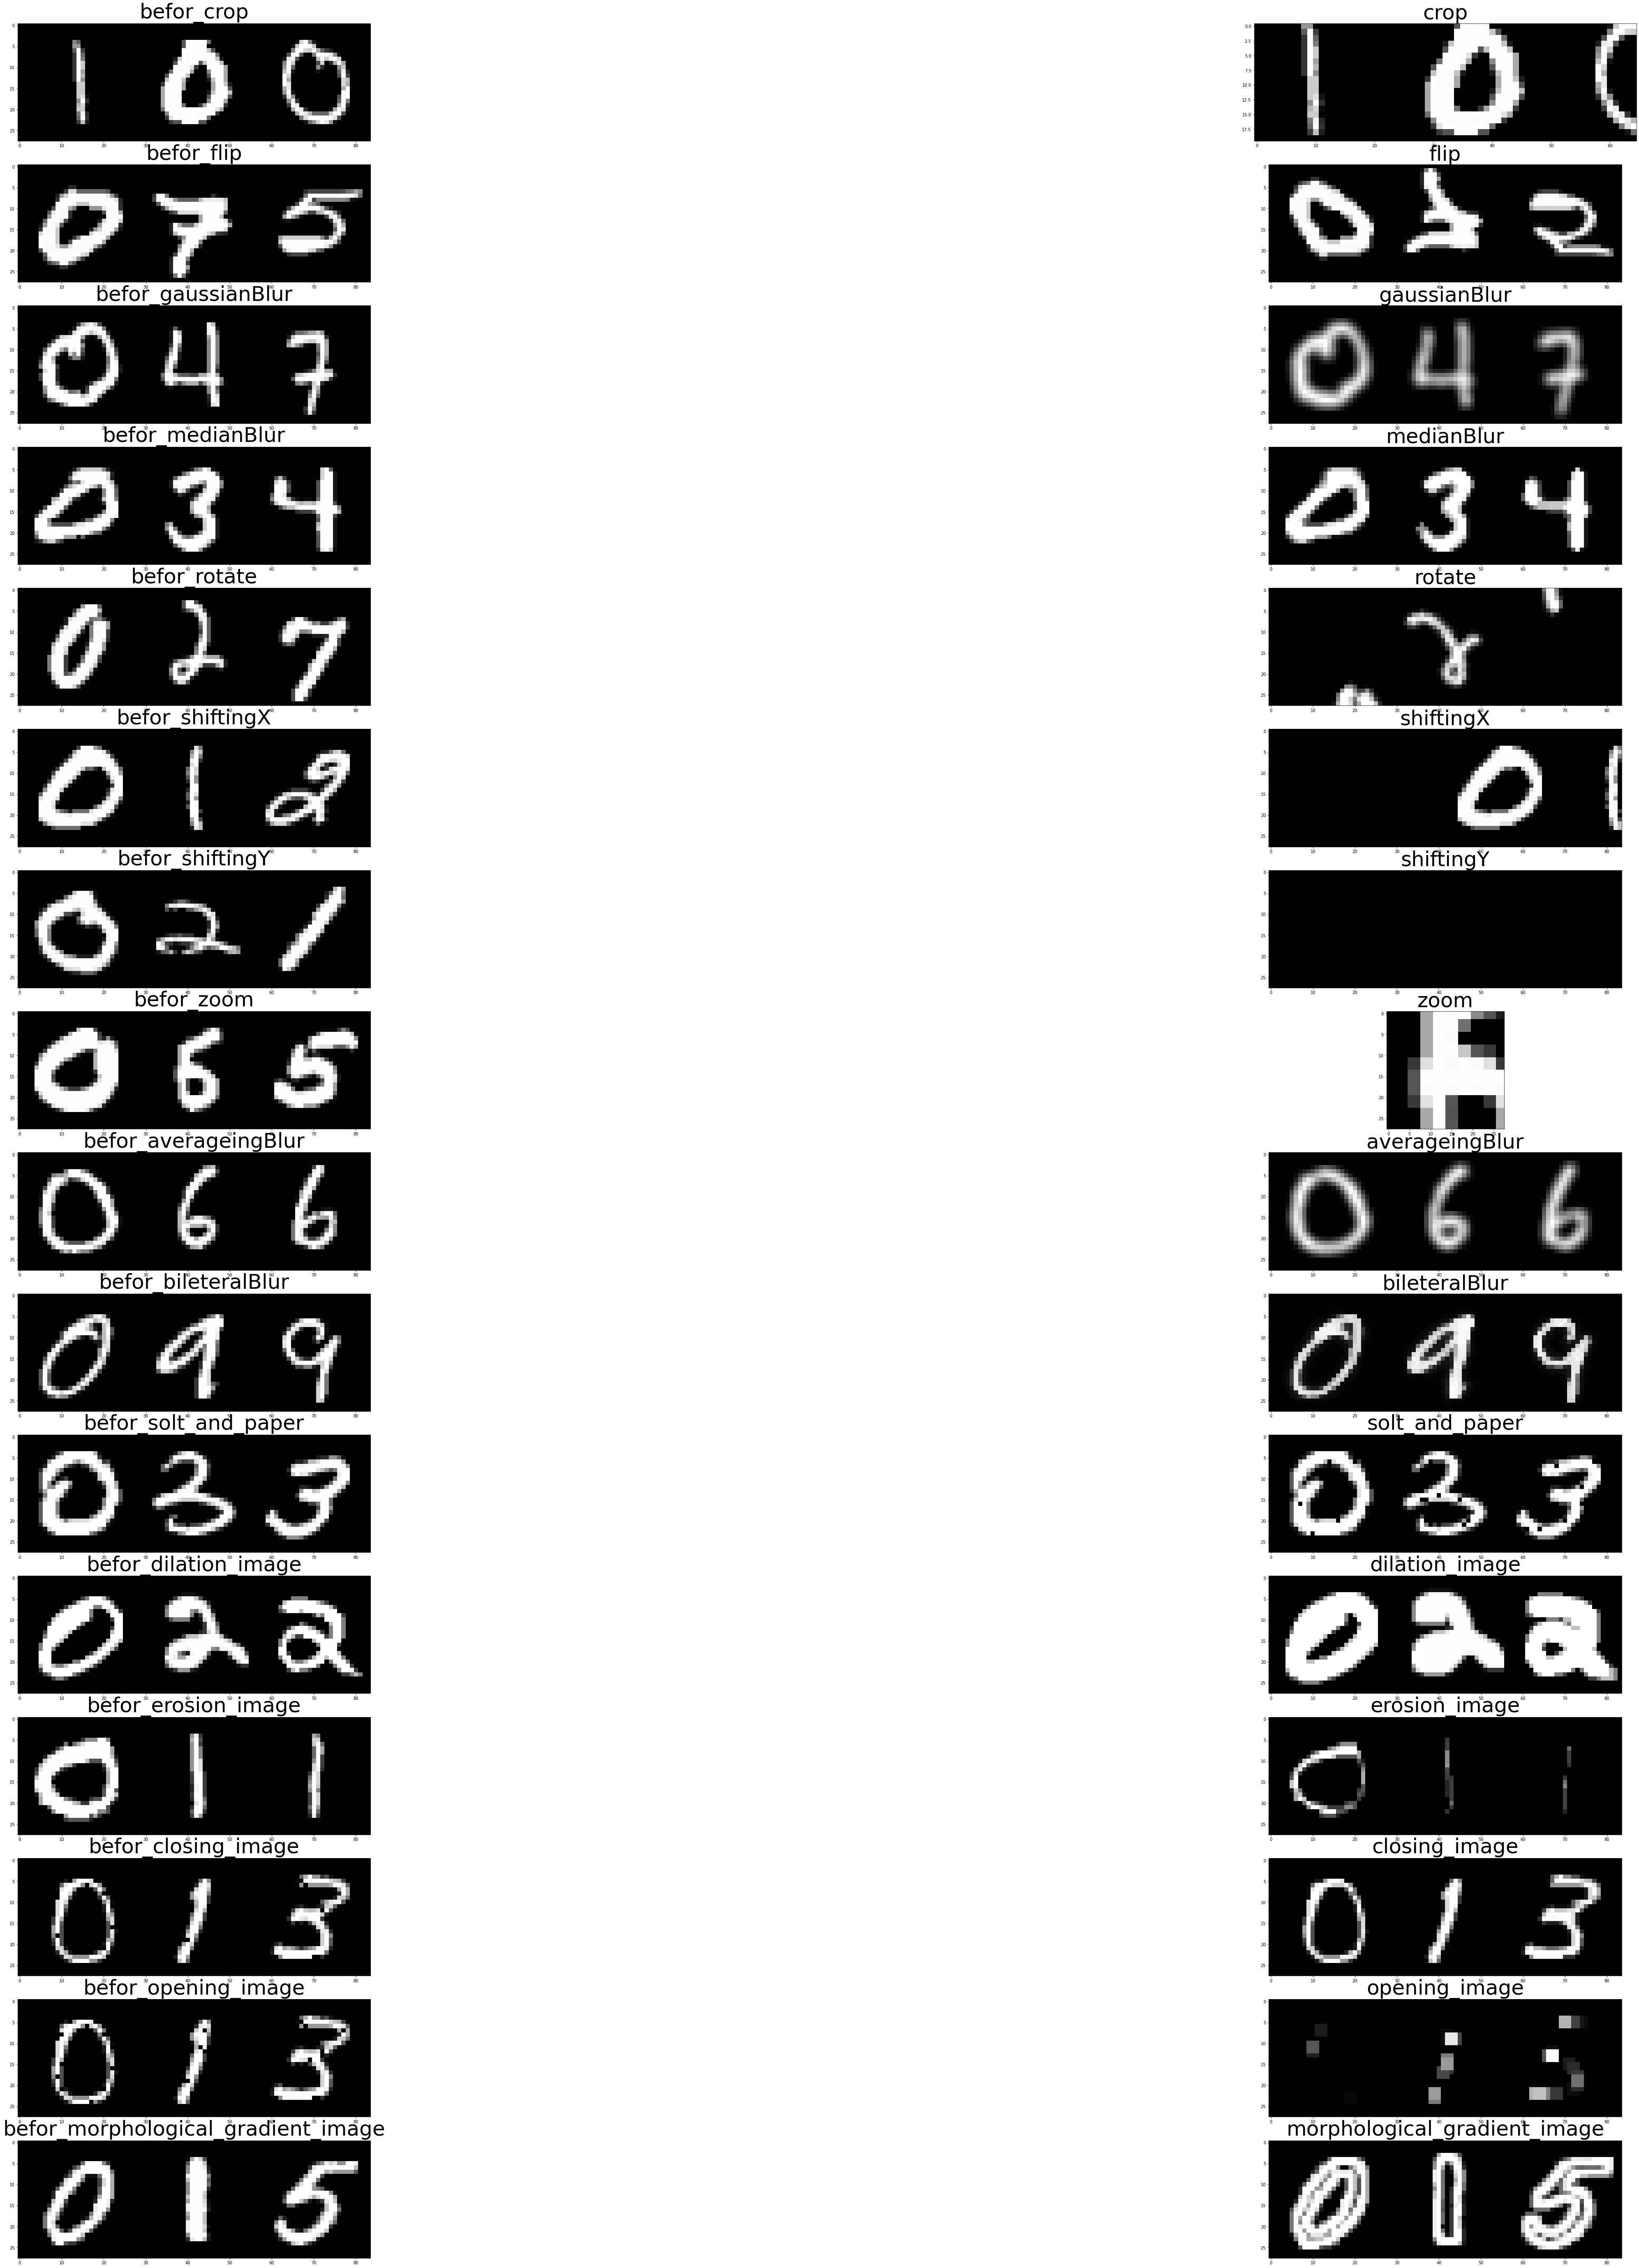

In [11]:
befor_crop = generate_image(full_digit_dic.get(100)[0])
crop = augmentation.Crop(befor_crop, (5, 5), (25, 70))

befor_flip = generate_image(full_digit_dic.get(75)[0])
flip = augmentation.Flip(befor_flip, 0)

befor_gaussianBlur = generate_image(full_digit_dic.get(47)[0])
gaussianBlur = augmentation.GaussianBlur(befor_gaussianBlur, (3, 3), 5)

befor_medianBlur = generate_image(full_digit_dic.get(34)[0])
medianBlur = augmentation.MedianBlur(befor_medianBlur, 3)

befor_rotate = generate_image(full_digit_dic.get(27)[0])
rotate = augmentation.Rotate(befor_rotate, 45)

befor_shiftingX = generate_image(full_digit_dic.get(12)[0])
shiftingX = augmentation.ShiftingX(befor_shiftingX, 40)

befor_shiftingY = generate_image(full_digit_dic.get(21)[0])
shiftingY = augmentation.ShiftingY(befor_shiftingX, -50)

befor_zoom = generate_image(full_digit_dic.get(55)[0])
zoom = augmentation.Zoom(befor_zoom, (14, 40), 3)

befor_averageingBlur = generate_image(full_digit_dic.get(66)[0])
averageingBlur = augmentation.averageingBlur(befor_averageingBlur, 3)

befor_bileteralBlur = generate_image(full_digit_dic.get(99)[0])
bileteralBlur = augmentation.bileteralBlur(befor_bileteralBlur, 4, 75, 75)

befor_solt_and_paper = generate_image(full_digit_dic.get(33)[0])
solt_and_paper = augmentation.solt_and_paper(befor_solt_and_paper, 0.5, 0.04)

befor_dilation_image = generate_image(full_digit_dic.get(22)[0])
dilation_image = augmentation.dilation_image(befor_dilation_image, 3)

befor_erosion_image = generate_image(full_digit_dic.get(11)[0])
erosion_image = augmentation.erosion_image(befor_erosion_image, 3)

befor_closing_image = generate_image(full_digit_dic.get(13)[0])
befor_closing_image = augmentation.solt_and_paper(befor_closing_image, 0.5, 0.04)
closing_image = augmentation.closing_image(befor_closing_image, 3)

befor_opening_image = generate_image(full_digit_dic.get(13)[0])
befor_opening_image = augmentation.solt_and_paper(befor_closing_image, 0.5, 0.04)
opening_image = augmentation.opening_image(befor_opening_image, 3)

befor_morphological_gradient_image = generate_image(full_digit_dic.get(15)[0])
morphological_gradient_image = augmentation.morphological_gradient_image(befor_morphological_gradient_image, 3)

all_images = [befor_crop, crop, befor_flip, flip, befor_gaussianBlur, gaussianBlur, befor_medianBlur, medianBlur, befor_rotate, rotate, befor_shiftingX, shiftingX, befor_shiftingY, shiftingY, befor_zoom, zoom, befor_averageingBlur, averageingBlur, befor_bileteralBlur, bileteralBlur, befor_solt_and_paper, solt_and_paper, befor_dilation_image, dilation_image, befor_erosion_image, erosion_image, befor_closing_image, closing_image, befor_opening_image, opening_image, befor_morphological_gradient_image, morphological_gradient_image] 
all_titles = ['befor_crop', 'crop', 'befor_flip', 'flip', 'befor_gaussianBlur', 'gaussianBlur', 'befor_medianBlur', 'medianBlur', 'befor_rotate', 'rotate', 'befor_shiftingX', 'shiftingX', 'befor_shiftingY', 'shiftingY', 'befor_zoom', 'zoom', 'befor_averageingBlur', 'averageingBlur', 'befor_bileteralBlur', 'bileteralBlur', 'befor_solt_and_paper', 'solt_and_paper', 'befor_dilation_image', 'dilation_image', 'befor_erosion_image', 'erosion_image', 'befor_closing_image', 'closing_image', 'befor_opening_image', 'opening_image', 'befor_morphological_gradient_image', 'morphological_gradient_image']           

plt.figure(figsize = (100, 100))

for i in range(len(all_images)):
    plt.subplot(16, 2, i+1)
    plt.imshow(all_images[i], cmap = plt.cm.gray)
    plt.title(all_titles[i], fontsize = 50)

plt.show()

# 1.F - sobel edges detection

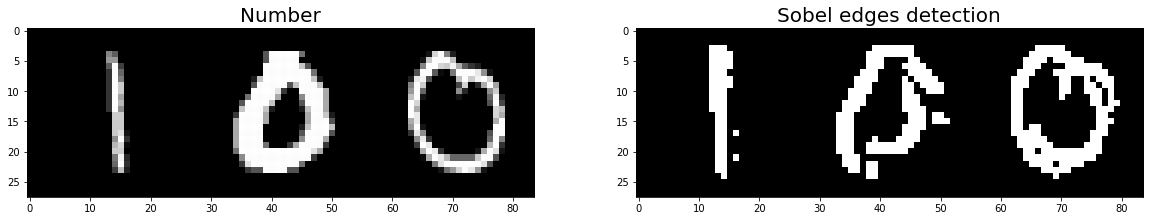

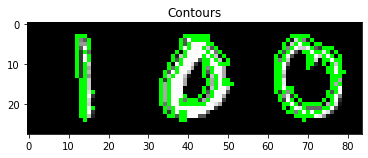

In [12]:
number = generate_image(full_digit_dic.get(100)[0])

sobel = sobel_edges_detection(number)
sobel=cv2.convertScaleAbs(sobel)

contours, _ = cv2.findContours(sobel.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)


canvas = number.copy()
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, contours, -1, (0,255,0))

imgs = [number, sobel]

titles = ['Number', 'Sobel edges detection']
plt.figure(figsize = (20, 10))

for i in range(len(imgs)):
    plt.subplot(1, 2, i+1)
    plt.imshow(imgs[i], cmap= 'gray')
    plt.title(titles[i], fontsize = 20)

plt.show()

plt.imshow(canvas)
plt.title('Contours')
plt.show()

# 1.F - canny edges detection

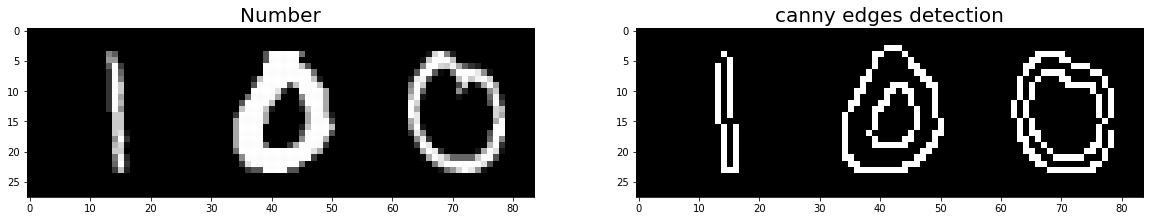

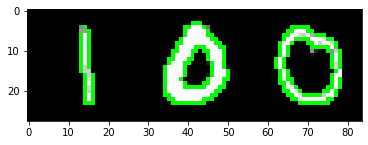

In [13]:
number = generate_image(full_digit_dic.get(100)[0])
canny = canny_edges_detection(number)

contours,_ = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

canvas = number.copy()
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, contours, -1, (0, 255, 0))

imgs = [number, canny]
titles = ['Number', 'canny edges detection']
plt.figure(figsize = (20, 10))

for i in range(len(imgs)):
    plt.subplot(1, 2, i+1)
    plt.imshow(imgs[i], cmap= 'gray')
    plt.title(titles[i], fontsize = 20)

plt.show()

plt.imshow(canvas)
plt.show()

# Summary of this part:
In this part, we had introduced the MNIST digits database.At first, I needed to load the data, save it in an accessible database and generate new numbers (0-100). Then to be able to build a strong model with low overfitting, a lot of data/images required. I created the augmentations class that manipulating the original images to generate new images. furthermore to detected edges, I applied two algorithms: Sobel and Canny edges detector, those contours which found (from each method) draw on the digit.The agumentations which used in this part: Crop, Flip, GaussianBlur, MedianBlur, Rotate, ShiftingX, ShiftingY, Zoom, averageingBlur, bileteralBlur, closing_image, dilation_image, erosion_image, morphological_gradient_image, opening_image, solt_and_paper. All of the augmentations generated new forms of the original digit and will help the model to be more flexible. some augmentations were create ruined pictures need to be reconsidered if helpful, like zoom, crop and axis shifting, rotate without reshaping and morphology transformations - opening (Useful for removing small objects). those augmentations destroy the digit entirety and it became unclear can't be recognized.

# Part 2 - generate and draw shapes

In [14]:
def draw_triangle(img, pts, color, thickness):
    return cv2.polylines(img, pts, True, color, thickness)

def draw_rectangle(img, p0, p1, color, thickness):
    return cv2.rectangle(img, p0, p1, color, thickness)
     
def draw_circular_shape(img, center_coordinates, axesLength, color, thickness, rotatation_angle = 0, perimeter_startAngle = 0 , perimeter_endAngle = 360 ):
    return cv2.ellipse(img, center_coordinates, axesLength, rotatation_angle, perimeter_startAngle, perimeter_endAngle, color, thickness)

def getL2(start, end):
    return np.linalg.norm(start-end)
    
def valid_coordinate(p0, p1, p2):
    """To be triangular you have to have a rule: every third edge need to be larger than the sum of the rest edges.
    The function calculates the euclidean norm to get the length of each edge. Then it checks if the triangular role valid"""
    first = getL2(p0, p1)
    second = getL2(p1, p2)
    third = getL2(p2, p0)
    condition1 = first < (second + third) 
    condition2 = second < (first + third)
    condition3 = third < (second + first)
    return condition1 and condition2 and condition3

def generate(img, size):
    """The function generet images from each shape option amount of size images"""
    h, w = img.shape[:2]
    all_images = []
    all_titles = []
    dic_shapes={'triangle': [], 'rectangle': [], 'circular': []}

    for i in range (size): #triangle
        y0, y1, y2 = np.random.choice(h, 3, replace = True)[:3]
        x0, x1, x2 = np.random.choice(w, 3, replace = True)[:3]

        p0 = np.array([y0, x0])
        p1 = np.array([y1, x1])
        p2 = np.array([y2, x2])
        r, g, b = np.random.choice(256, 3, replace = True)[:3]
        thickness = 1 
        while True:            
            if valid_coordinate(p0, p1, p2):
                break
            else:# if-else it looks for another point to fit in
                y2 = np.random.choice(h)
                x2 = np.random.choice(w)
                p2 = np.array([y2, x2])
        pts = np.array([p0, p1, p2], dtype=np.int32)
        triangle = draw_triangle(img.copy(), [pts], (int(r),int(g),int(b)), thickness)
        all_images.append(triangle)
        all_titles.append(f'triangle\npoints: {p0}, {p1}, {p2} ')
        dic_shapes['triangle'].append(triangle)


    for i in range(size): #rectangle
        y = np.random.choice(h, 2, replace = True)
        x = np.random.choice(w, 2, replace = True)
        thickness = 1
        r, g, b = np.random.choice(256, 3, replace = True)[:3]
        p0, p1 = (y[0], x[0]), (y[1], x[1])
        rectangle = draw_rectangle(img.copy(), p0, p1, (int(r),int(g),int(b)), thickness)
        all_images.append(rectangle)
        all_titles.append(f'rectangle\npoints: {p0}, {p1} ')
        dic_shapes['rectangle'].append(rectangle)



    for i in range(size): #circular: ellipse or circle
        thickness = 1
        center_y = np.random.randint(1,h-thickness)
        center_x = np.random.randint(1, w-thickness)
        rotatation_angle = 0 
        primary_radius = min(center_y, abs(h-center_y-thickness))
        minnor_radius = min(center_x,abs(w-center_x-thickness))
        if primary_radius >  1:
            primary_radius = np.random.randint(1, primary_radius)
        if minnor_radius > 1:
            minnor_radius = np.random.randint(1, minnor_radius)
        r, g, b = np.random.choice(256, 3, replace = True)[:3]
        center_coordinates, axesLength = (center_y, center_x), (primary_radius, minnor_radius)
        temp = draw_circular_shape(img.copy(), center_coordinates, axesLength, (int(r),int(g),int(b)), thickness, rotatation_angle)
        all_images.append(temp)
        all_titles.append(f'circular\ncenter: {center_coordinates} radius: {axesLength} ')
        dic_shapes['circular'].append(temp)

    return all_images, all_titles, dic_shapes

# 2 a - sample of the generated images

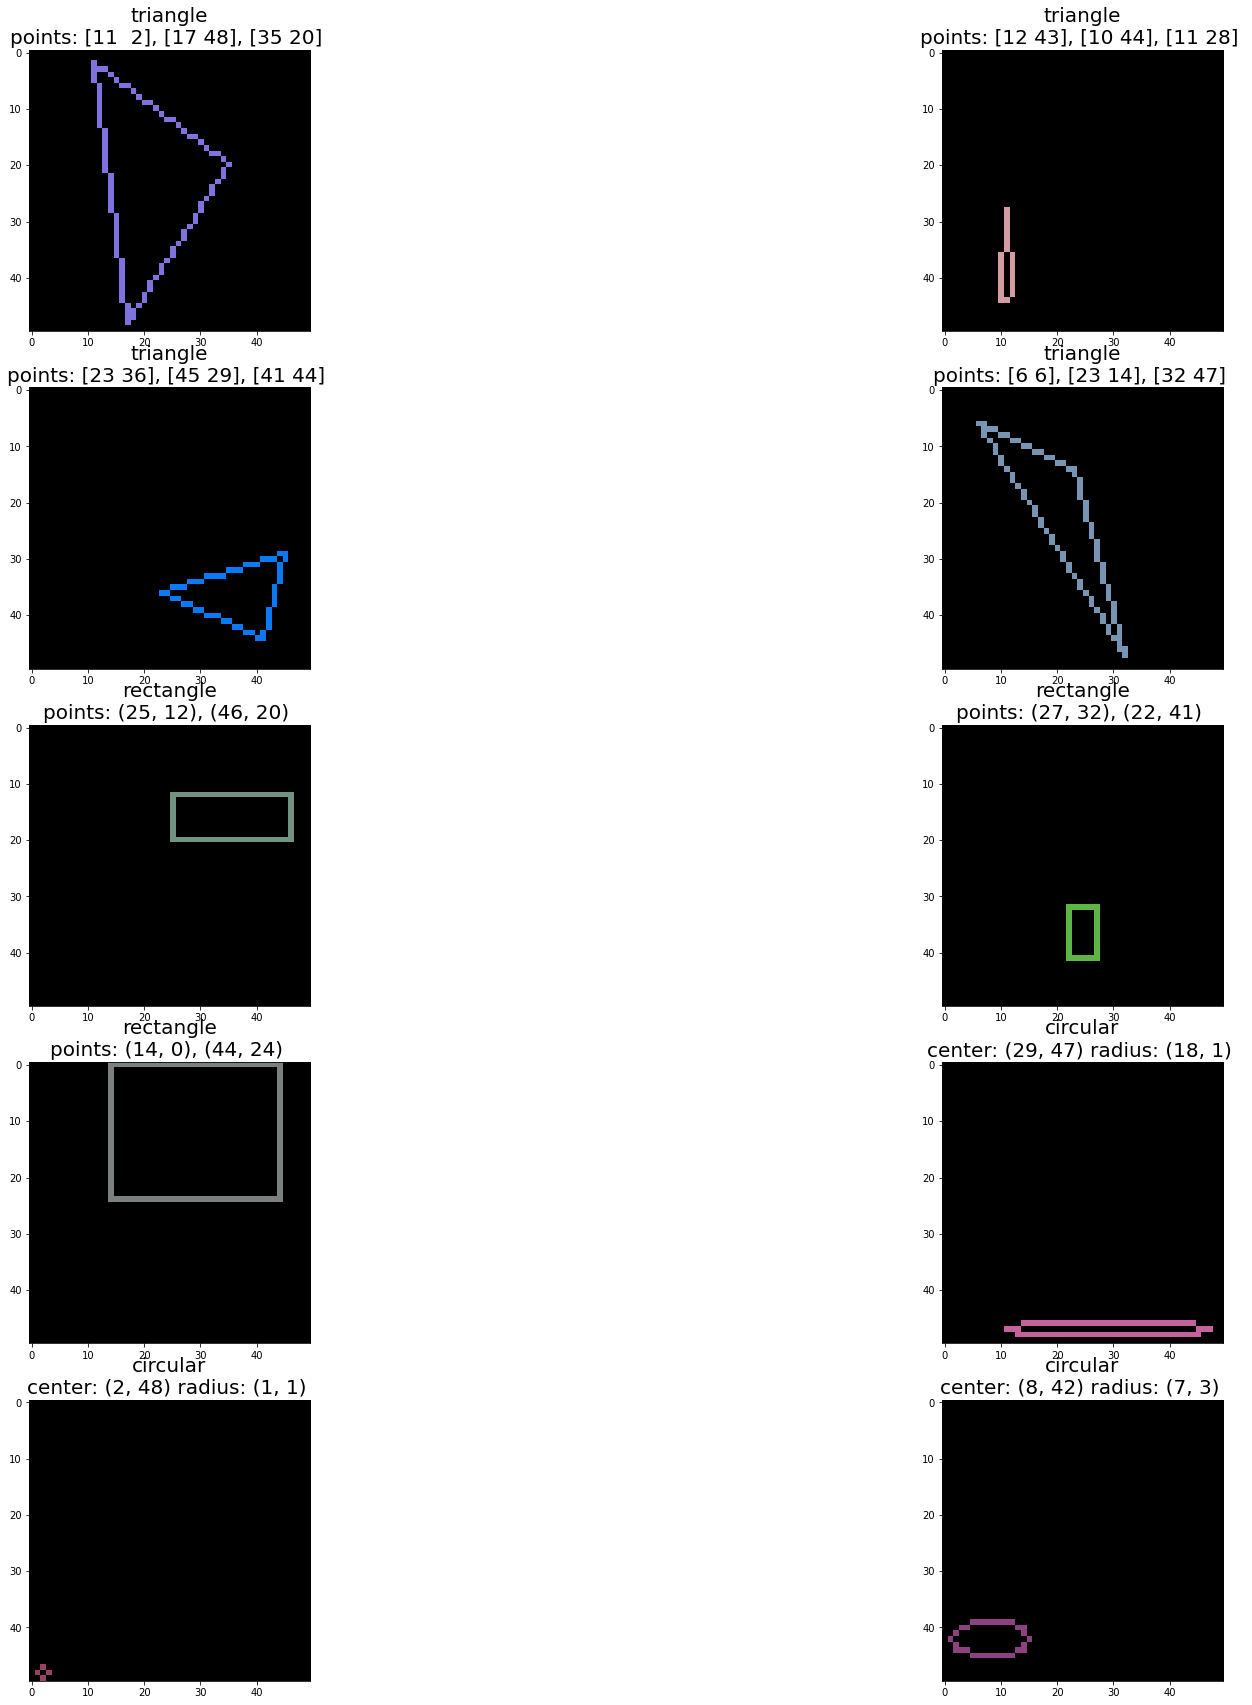

In [15]:
img = np.zeros((50, 50, 3), np.uint8) 
size = 300
imgs, tits, shapes = generate(img, size) 

plt.figure(figsize = (30, 30))

k=1
for i in range(0, len(imgs), 90):
    plt.subplot(5, 2, k)
    plt.imshow(imgs[i])
    plt.title(tits[i], fontsize = 20)
    k+=1

plt.show()    

# 2 c - split to train and test

In [16]:
def split_train_test(data, p = 0.2):
    raw_data = []
    for shape, images_list in data.items(): #flatten the database into long list shape is the categorical value 
        for img in images_list: #Associate image shape to create a tuple
            raw_data.append((img, shape))
    raw_data = np.array(raw_data)
    np.random.shuffle(raw_data)
    barrier = int(np.round(len(raw_data) * (1- p)))
    train, test = raw_data[:barrier], raw_data[barrier:]
    train_x, train_y = train[:, 0], train[:, 1]
    test_x, test_y = test[:, 0], test[:, 1]
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = split_train_test(shapes)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

720 720
180 180


# 2 b - Calculate augmentations and plot

In [17]:
def get3_shapes(dic, size):
    """The function selects an image from a list by randomly selecting an index"""
    index = np.random.randint(size)
    return dic['triangle'][index], dic['rectangle'][index], dic['circular'][index]

def subplot(rows, cols, images, titles):
    plt.figure(figsize=(50, 50))
    for i in range(rows*cols+1):
        try:
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i])
            plt.title(titles[i], fontsize = 30)
            i += 1
        except:
            pass # end of images

    plt.show()

# augmentation: Crop

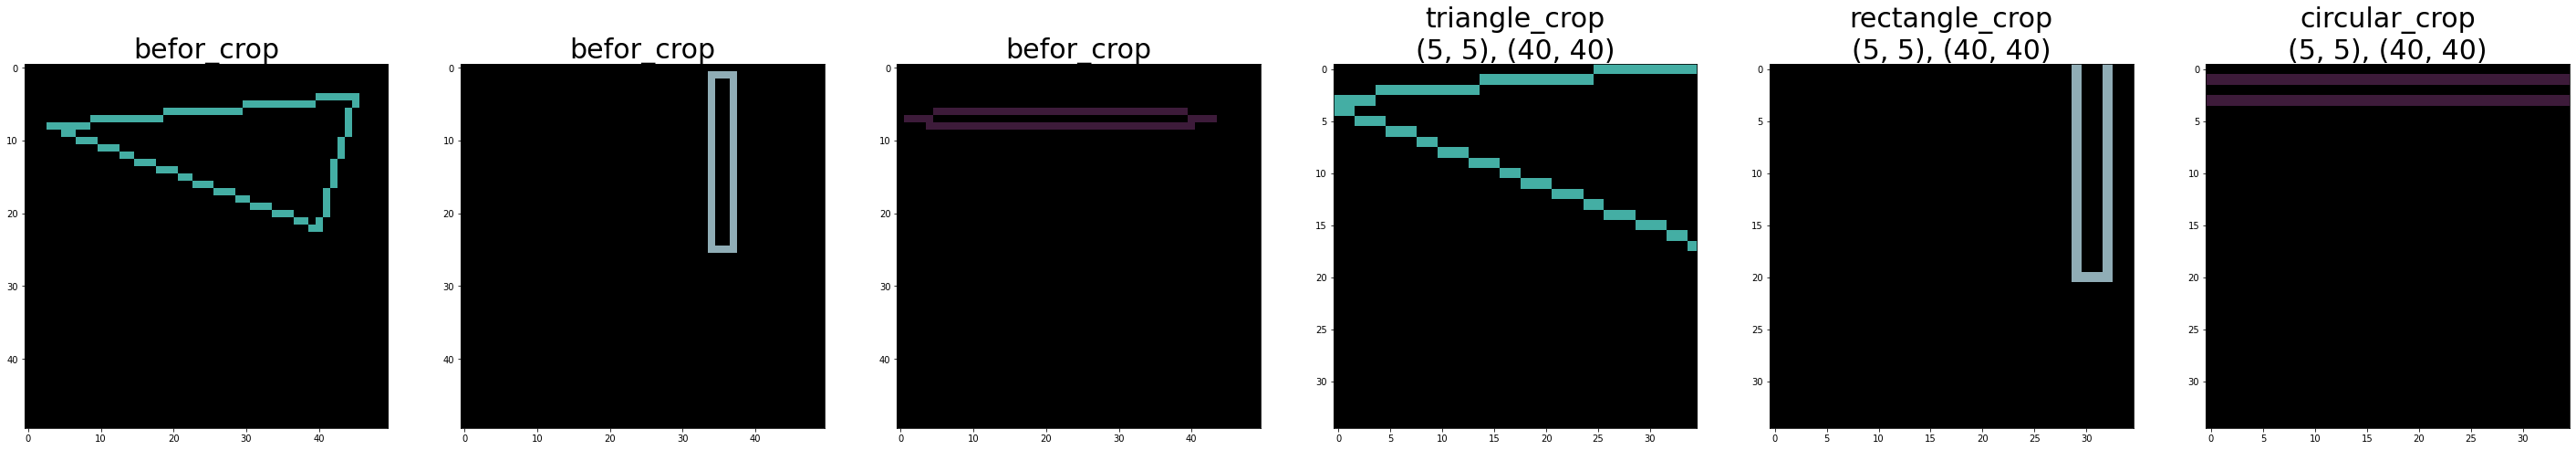

In [18]:
befor_crop = get3_shapes(shapes, size)
triangle_crop = augmentation.Crop(befor_crop[0], (5, 5), (40, 40))
rectangle_crop = augmentation.Crop(befor_crop[1], (5, 5), (40, 40))
circular_crop = augmentation.Crop(befor_crop[2], (5, 5), (40, 40))
all_images = [befor_crop[0], befor_crop[1], befor_crop[2], triangle_crop, rectangle_crop, circular_crop]

all_titles = ['befor_crop', 'befor_crop', 'befor_crop', 'triangle_crop\n(5, 5), (40, 40)', 'rectangle_crop\n(5, 5), (40, 40)', 'circular_crop\n(5, 5), (40, 40)']           

subplot(1, 6, all_images, all_titles)

# augmentation: Flip

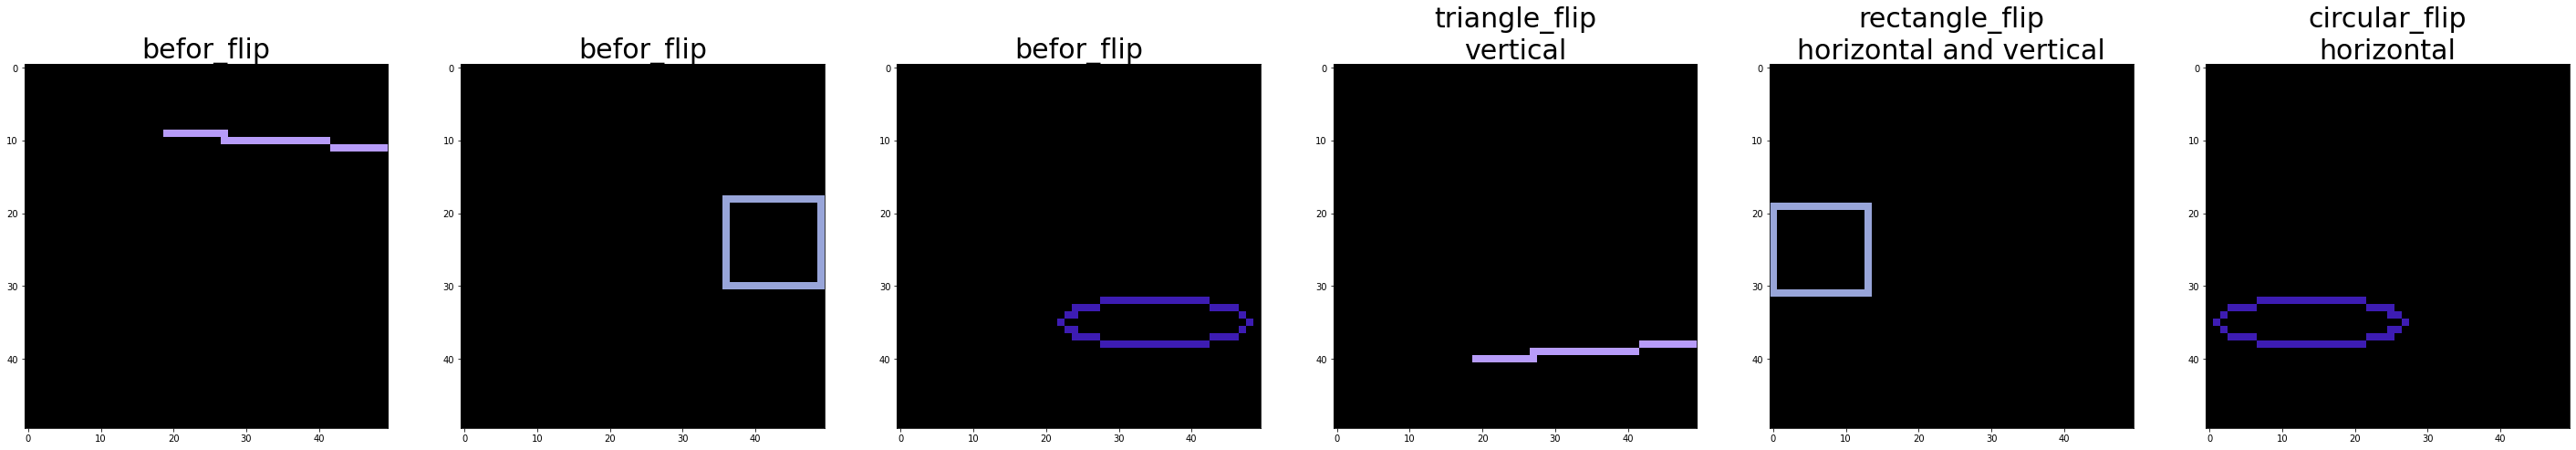

In [19]:
befor_flip = get3_shapes(shapes, size)
triangle_flip = augmentation.Flip(befor_flip[0], 0)
rectangle_flip = augmentation.Flip(befor_flip[1], -1)
circular_flip = augmentation.Flip(befor_flip[2], 1)
all_images = [befor_flip[0], befor_flip[1], befor_flip[2], triangle_flip, rectangle_flip, circular_flip]

all_titles = ['befor_flip', 'befor_flip', 'befor_flip', 'triangle_flip\nvertical', 'rectangle_flip\nhorizontal and vertical', 'circular_flip\nhorizontal']           

subplot(1, 6, all_images, all_titles)

# augmentation: GaussianBlur

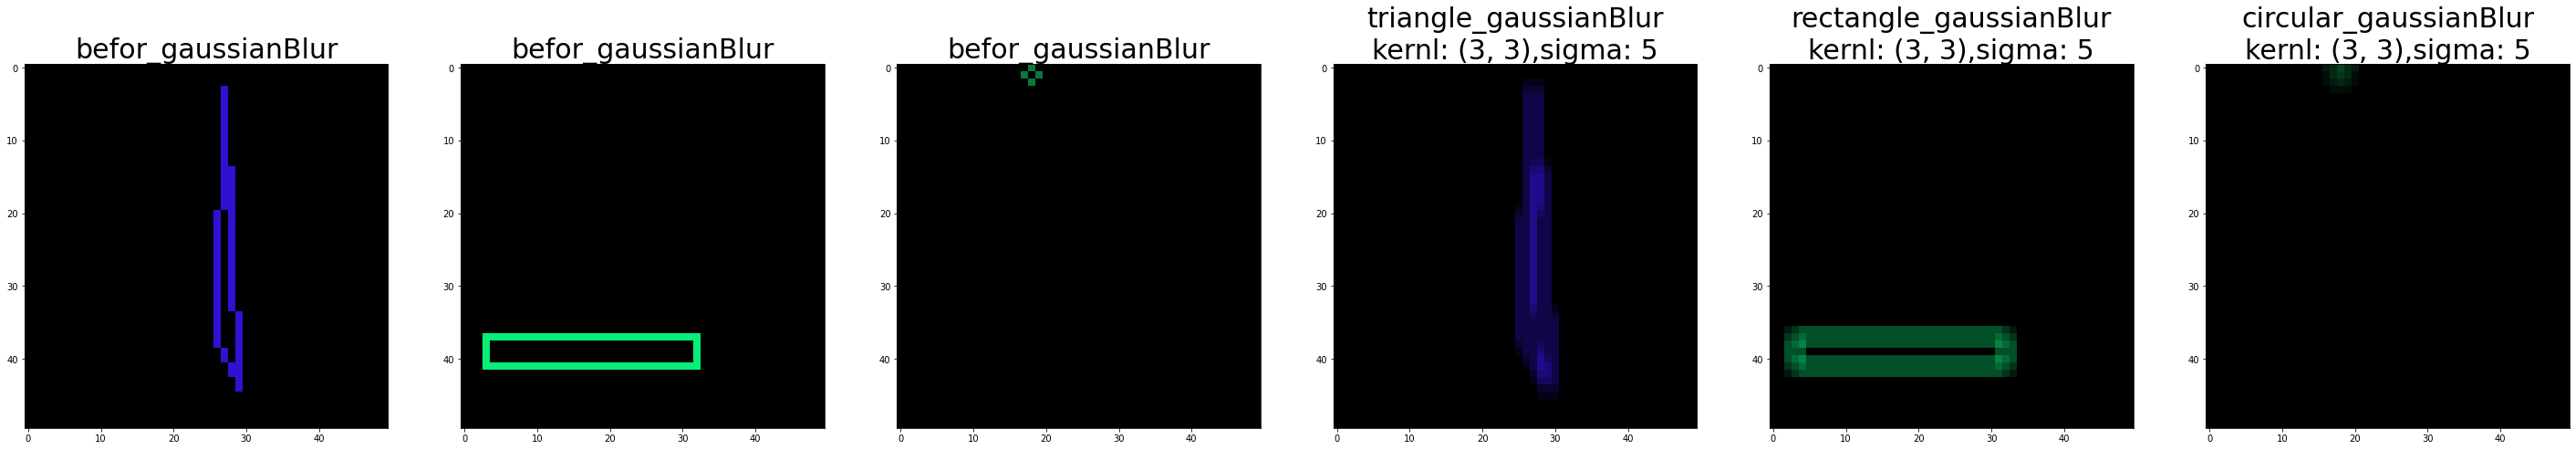

In [20]:
befor_gaussianBlur = get3_shapes(shapes, size)
triangle_gaussianBlur = augmentation.GaussianBlur(befor_gaussianBlur[0],(3, 3), 5)
rectangle_gaussianBlur = augmentation.GaussianBlur(befor_gaussianBlur[1], (3, 3), 5)
circular_gaussianBlur = augmentation.GaussianBlur(befor_gaussianBlur[2], (3, 3), 5)
all_images = [befor_gaussianBlur[0], befor_gaussianBlur[1], befor_gaussianBlur[2], triangle_gaussianBlur, rectangle_gaussianBlur, circular_gaussianBlur]

all_titles = ['befor_gaussianBlur', 'befor_gaussianBlur', 'befor_gaussianBlur', 'triangle_gaussianBlur\nkernl: (3, 3),sigma: 5', 'rectangle_gaussianBlur\nkernl: (3, 3),sigma: 5', 'circular_gaussianBlur\nkernl: (3, 3),sigma: 5']           

subplot(1, 6, all_images, all_titles)

# augmentation: MedianBlur

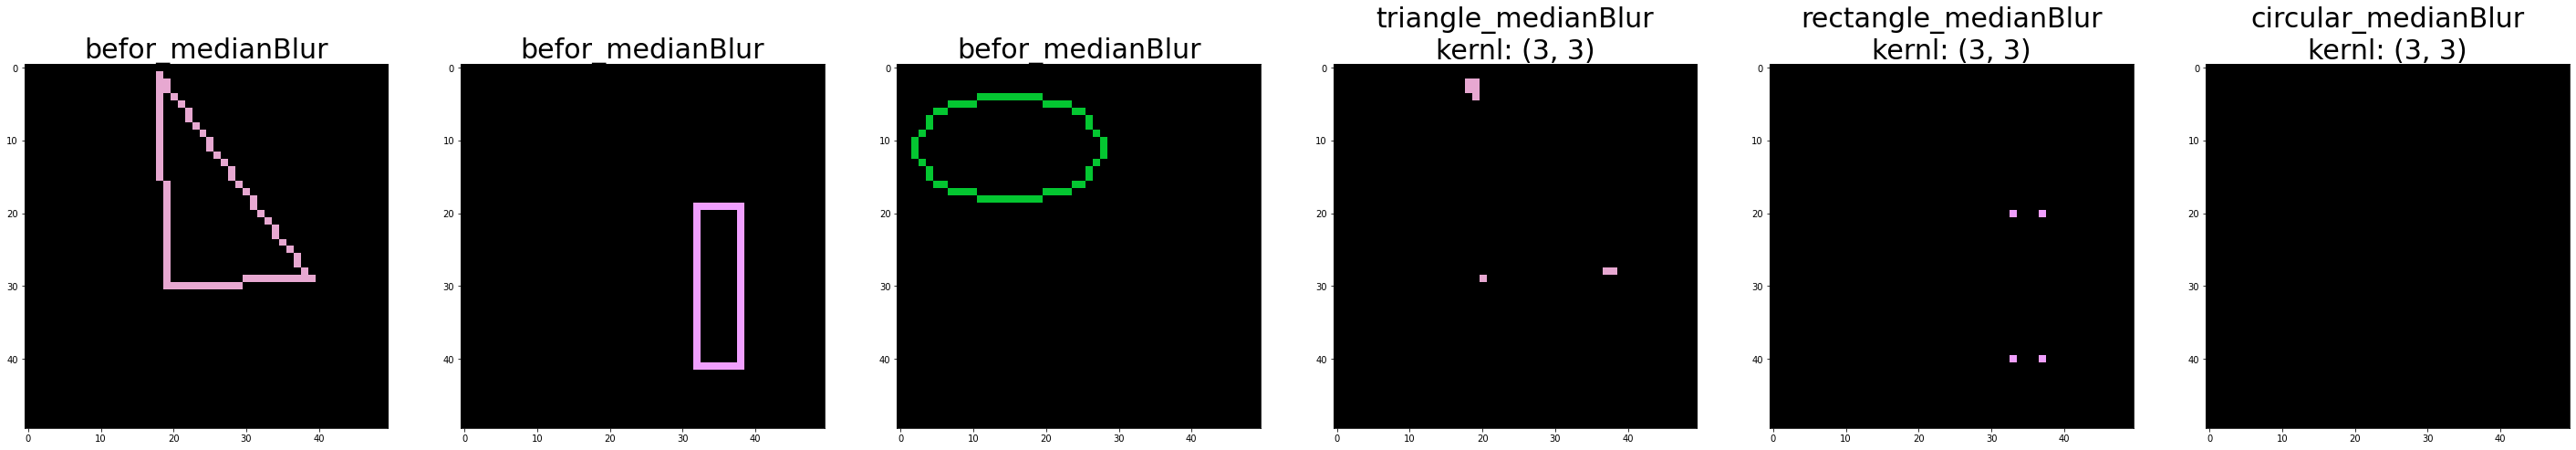

In [21]:
befor_medianBlur = get3_shapes(shapes, size)
triangle_medianBlur = augmentation.MedianBlur(befor_medianBlur[0], 3)
rectangle_medianBlur = augmentation.MedianBlur(befor_medianBlur[1], 3)
circular_medianBlur = augmentation.MedianBlur(befor_medianBlur[2], 3)
all_images = [befor_medianBlur[0], befor_medianBlur[1], befor_medianBlur[2], triangle_medianBlur, rectangle_medianBlur, circular_medianBlur]

all_titles = ['befor_medianBlur', 'befor_medianBlur', 'befor_medianBlur', 'triangle_medianBlur\nkernl: (3, 3)', 'rectangle_medianBlur\nkernl: (3, 3)', 'circular_medianBlur\nkernl: (3, 3)']           

subplot(1, 6, all_images, all_titles)

# augmentation: Rotate

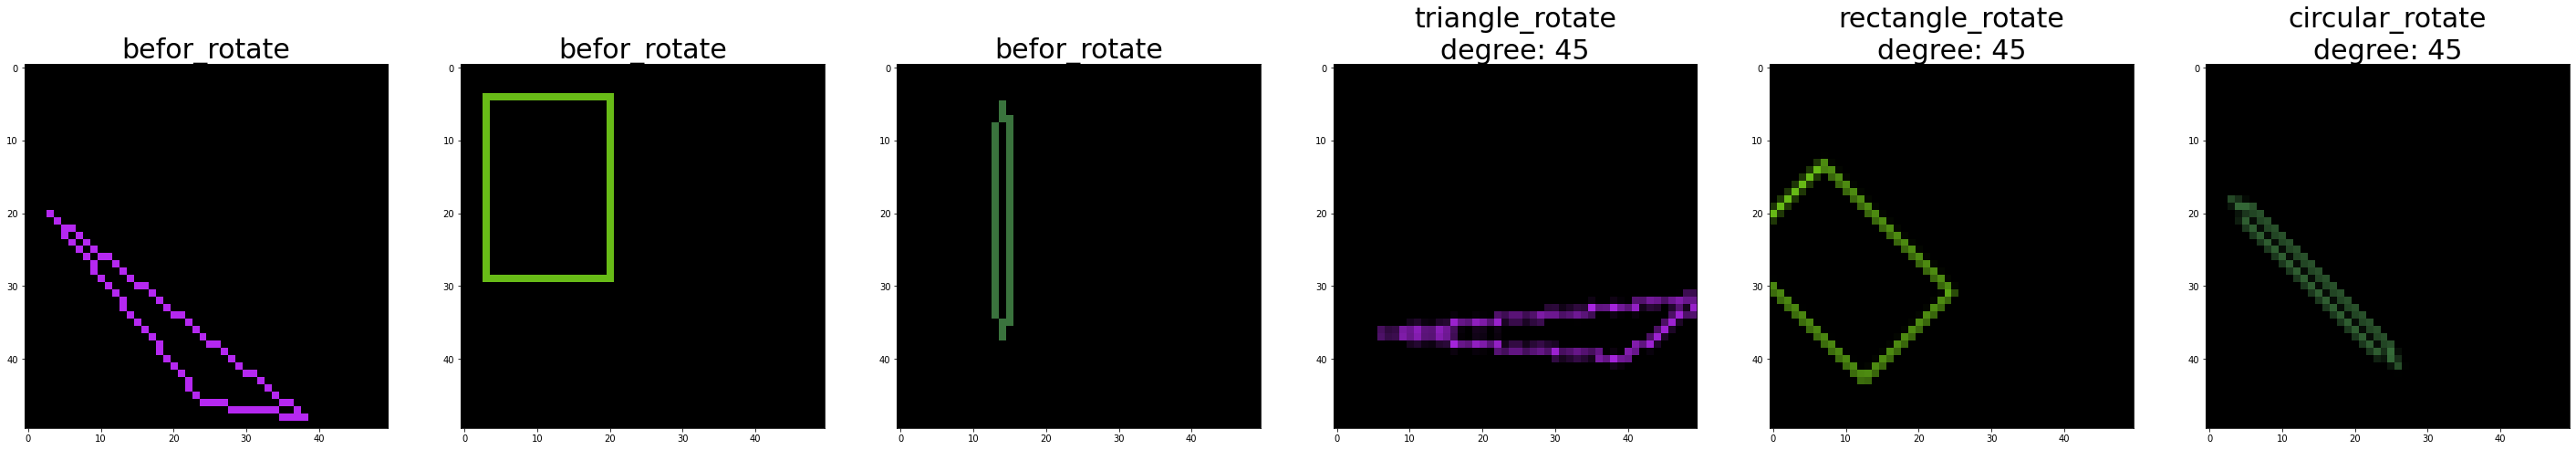

In [22]:
befor_rotate = get3_shapes(shapes, size)
triangle_rotate = augmentation.Rotate(befor_rotate[0], 45)
rectangle_rotate = augmentation.Rotate(befor_rotate[1], 45)
circular_rotate = augmentation.Rotate(befor_rotate[2], 45)
all_images = [befor_rotate[0], befor_rotate[1], befor_rotate[2], triangle_rotate, rectangle_rotate, circular_rotate]

all_titles = ['befor_rotate', 'befor_rotate', 'befor_rotate', 'triangle_rotate\ndegree: 45', 'rectangle_rotate\ndegree: 45', 'circular_rotate\ndegree: 45']           

subplot(1, 6, all_images, all_titles)

# augmentation: Shifting by X axis

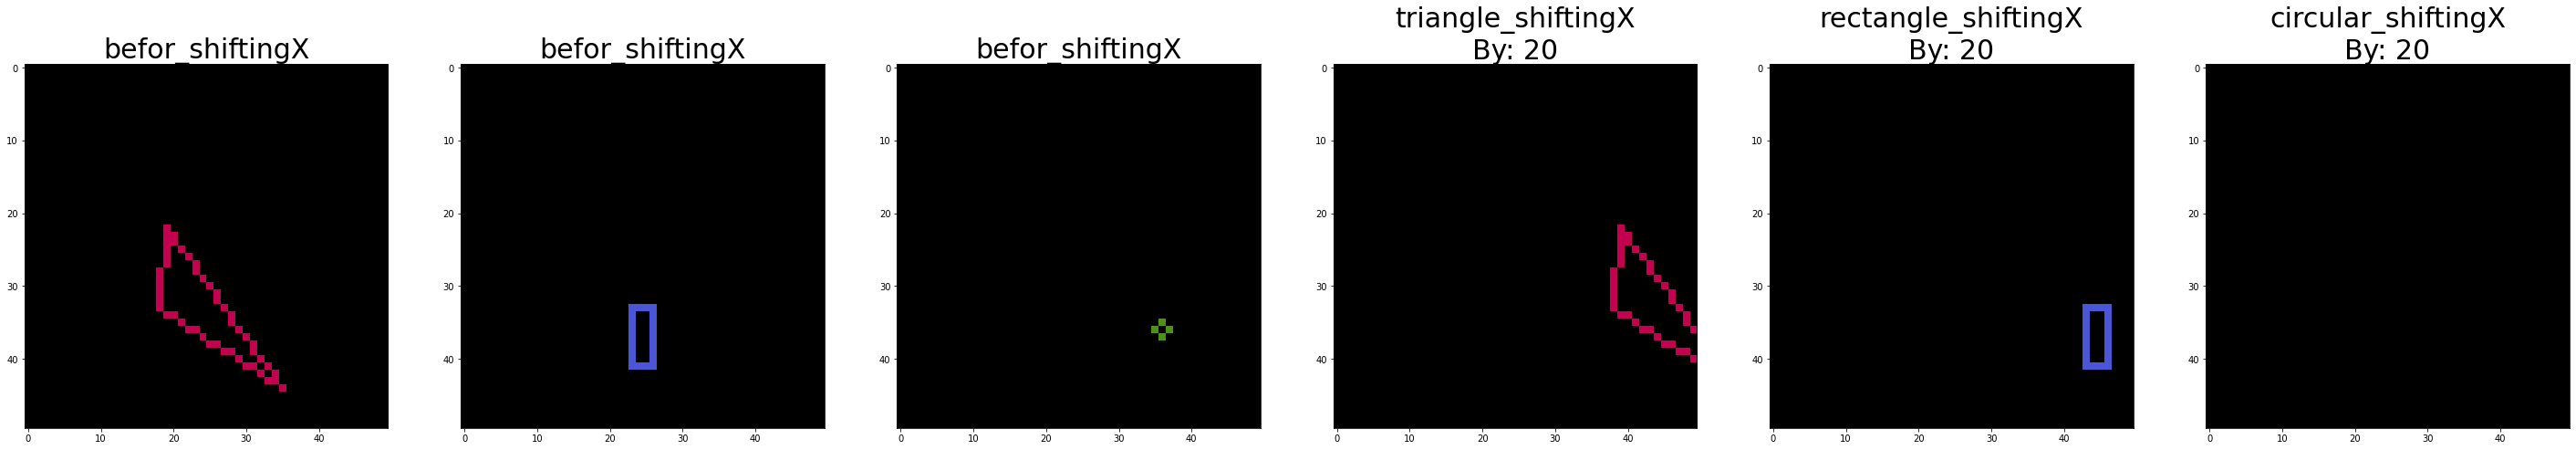

In [23]:
befor_shiftingX = get3_shapes(shapes, size)
triangle_shiftingX = augmentation.ShiftingX(befor_shiftingX[0], 20)
rectangle_shiftingX = augmentation.ShiftingX(befor_shiftingX[1], 20)
circular_shiftingX = augmentation.ShiftingX(befor_shiftingX[2], 20)
all_images = [befor_shiftingX[0], befor_shiftingX[1], befor_shiftingX[2], triangle_shiftingX, rectangle_shiftingX, circular_shiftingX]

all_titles = ['befor_shiftingX', 'befor_shiftingX', 'befor_shiftingX', 'triangle_shiftingX\nBy: 20', 'rectangle_shiftingX\nBy: 20', 'circular_shiftingX\nBy: 20']           

subplot(1, 6, all_images, all_titles)

# augmentation: Shifting by Y axis

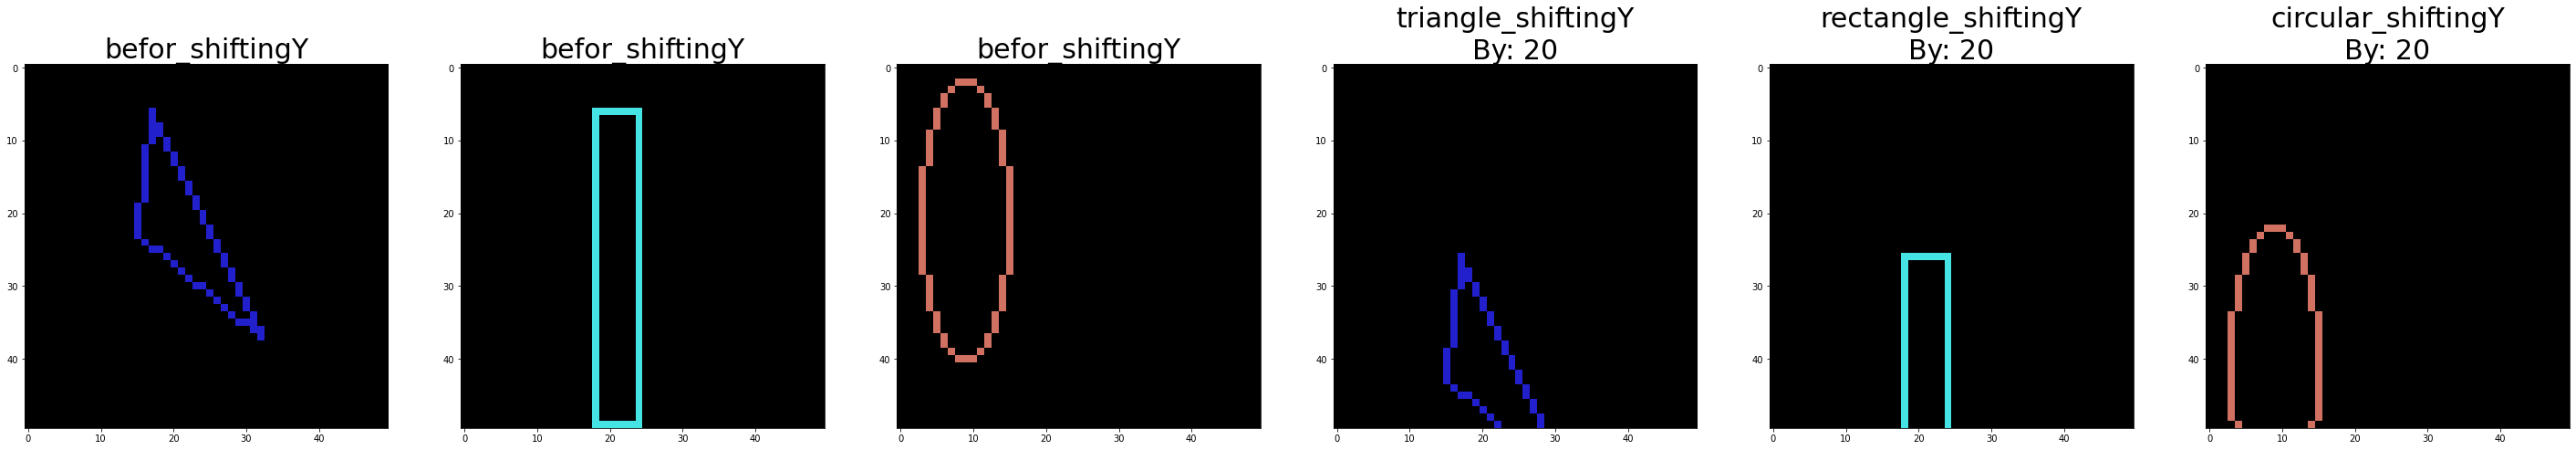

In [24]:
befor_shiftingY = get3_shapes(shapes, size)
triangle_shiftingY = augmentation.ShiftingY(befor_shiftingY[0], 20)
rectangle_shiftingY = augmentation.ShiftingY(befor_shiftingY[1], 20)
circular_shiftingY = augmentation.ShiftingY(befor_shiftingY[2], 20)
all_images = [befor_shiftingY[0], befor_shiftingY[1], befor_shiftingY[2], triangle_shiftingY, rectangle_shiftingY, circular_shiftingY]

all_titles = ['befor_shiftingY', 'befor_shiftingY', 'befor_shiftingY', 'triangle_shiftingY\nBy: 20', 'rectangle_shiftingY\nBy: 20', 'circular_shiftingY\nBy: 20']           

subplot(1, 6, all_images, all_titles)

# augmentation: Zoom

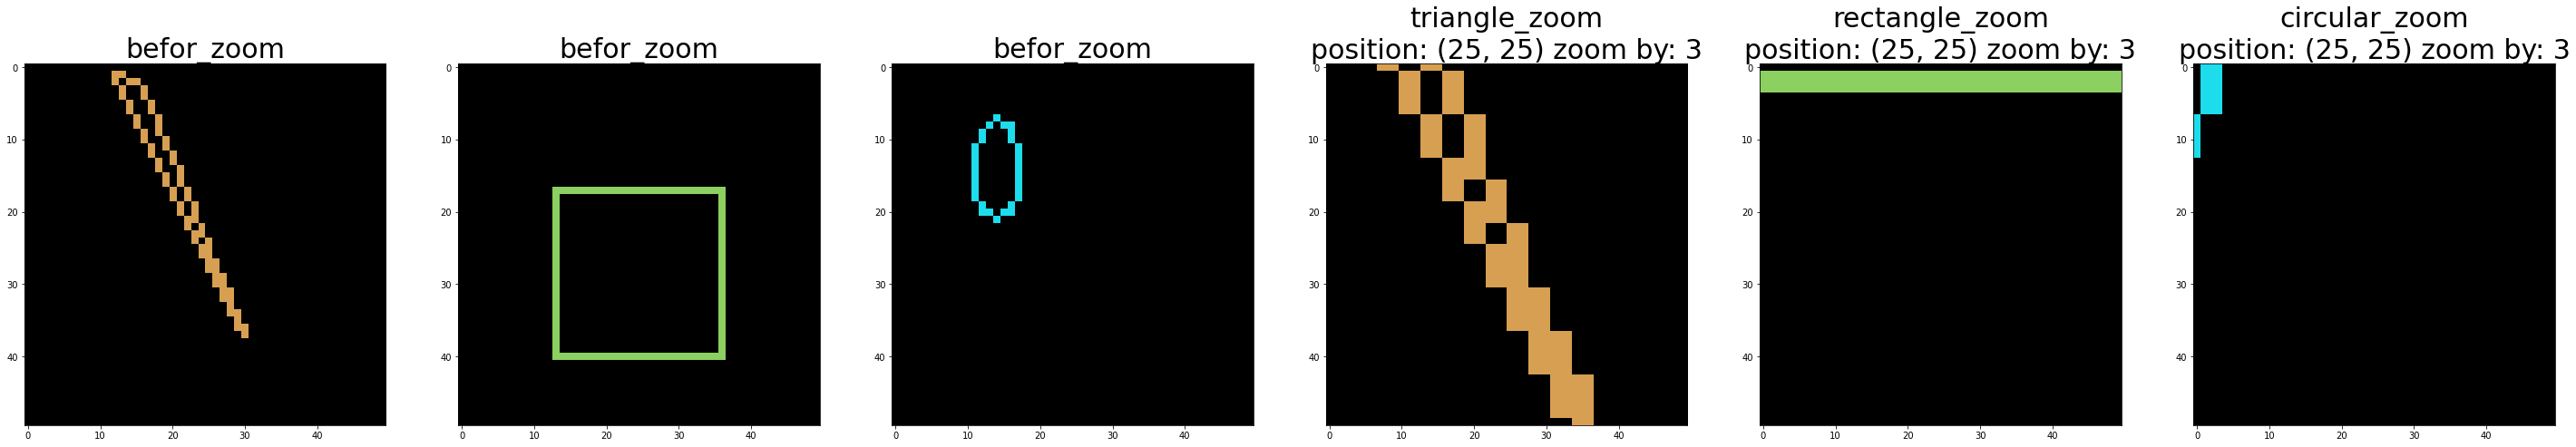

In [25]:
befor_zoom = get3_shapes(shapes, size)
triangle_zoom = augmentation.Zoom(befor_zoom[0], (25, 25), 3)
rectangle_zoom = augmentation.Zoom(befor_zoom[1], (25, 25), 3)
circular_zoom = augmentation.Zoom(befor_zoom[2], (25, 25), 3)
all_images = [befor_zoom[0], befor_zoom[1], befor_zoom[2], triangle_zoom, rectangle_zoom, circular_zoom]

all_titles = ['befor_zoom', 'befor_zoom', 'befor_zoom', 'triangle_zoom\nposition: (25, 25) zoom by: 3', 'rectangle_zoom\nposition: (25, 25) zoom by: 3', 'circular_zoom\nposition: (25, 25) zoom by: 3']           

subplot(1, 6, all_images, all_titles)

# augmentation: averageingBlur

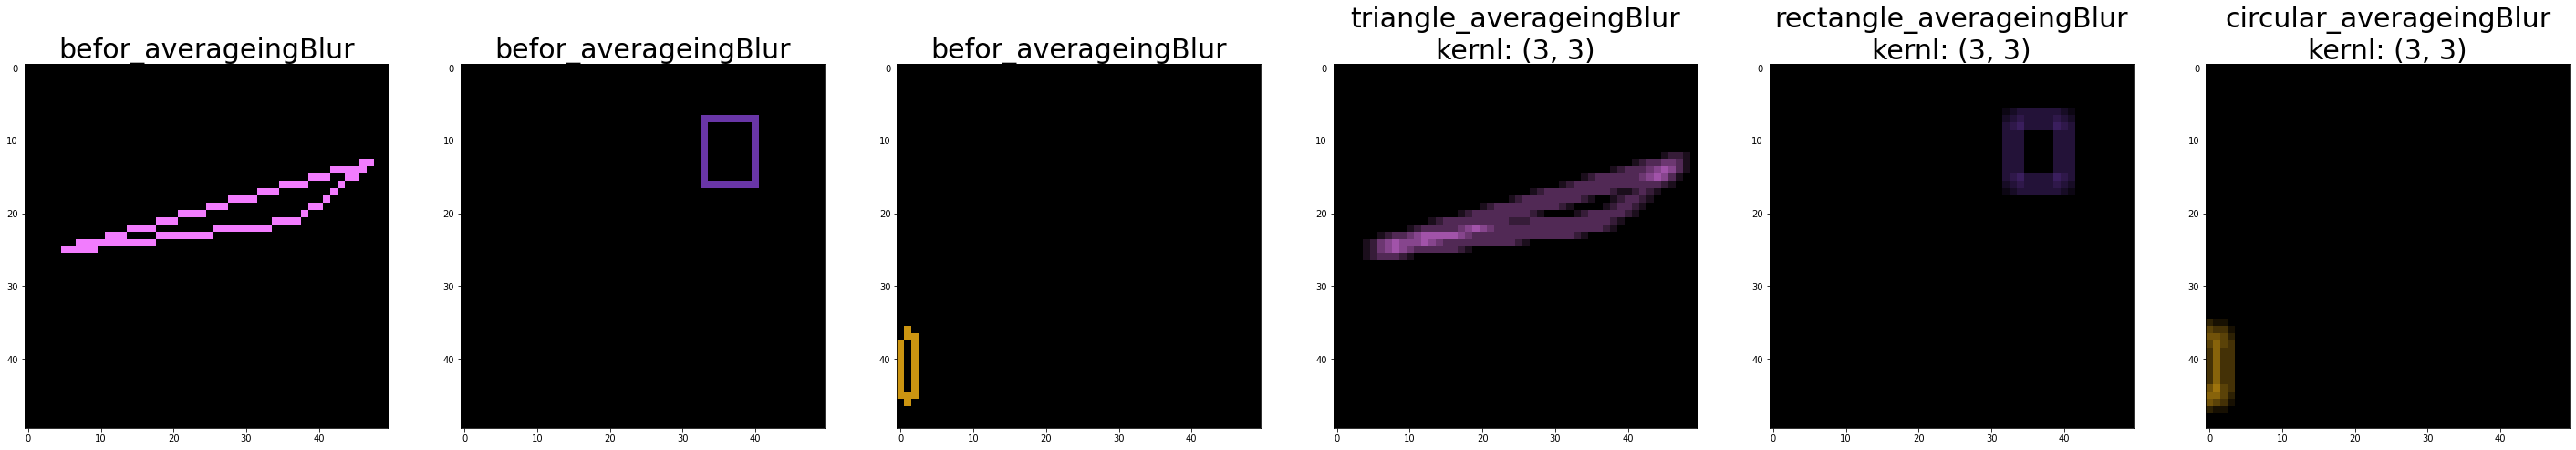

In [26]:
befor_averageingBlur = get3_shapes(shapes, size)
triangle_averageingBlur = augmentation.averageingBlur(befor_averageingBlur[0], 3)
rectangle_averageingBlur = augmentation.averageingBlur(befor_averageingBlur[1], 3)
circular_averageingBlur = augmentation.averageingBlur(befor_averageingBlur[2], 3)
all_images = [befor_averageingBlur[0], befor_averageingBlur[1], befor_averageingBlur[2], triangle_averageingBlur, rectangle_averageingBlur, circular_averageingBlur]

all_titles = ['befor_averageingBlur', 'befor_averageingBlur', 'befor_averageingBlur', 'triangle_averageingBlur\nkernl: (3, 3)', 'rectangle_averageingBlur\nkernl: (3, 3)', 'circular_averageingBlur\nkernl: (3, 3)']           

subplot(1, 6, all_images, all_titles)

# augmentation: bileteralBlur

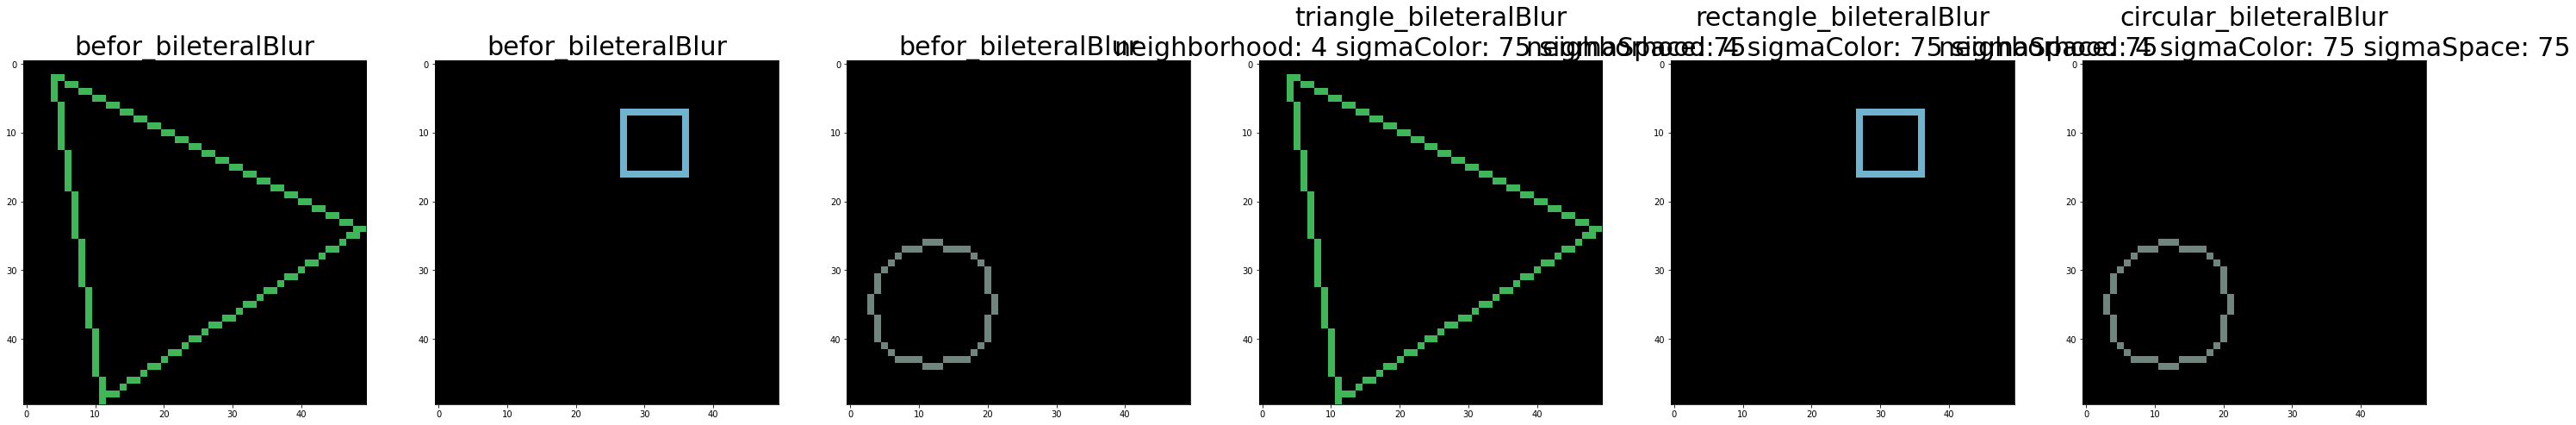

In [27]:
befor_bileteralBlur = get3_shapes(shapes, size)
triangle_bileteralBlur = augmentation.bileteralBlur(befor_bileteralBlur[0], 4, 75, 75)
rectangle_bileteralBlur = augmentation.bileteralBlur(befor_bileteralBlur[1], 4, 75, 75)
circular_bileteralBlur = augmentation.bileteralBlur(befor_bileteralBlur[2], 4, 75, 75)
all_images = [befor_bileteralBlur[0], befor_bileteralBlur[1], befor_bileteralBlur[2], triangle_bileteralBlur, rectangle_bileteralBlur, circular_bileteralBlur]
all_titles = ['befor_bileteralBlur', 'befor_bileteralBlur', 'befor_bileteralBlur', 'triangle_bileteralBlur\nneighborhood: 4 sigmaColor: 75 sigmaSpace: 75', 'rectangle_bileteralBlur\nneighborhood: 4 sigmaColor: 75 sigmaSpace: 75', 'circular_bileteralBlur\nneighborhood: 4 sigmaColor: 75 sigmaSpace: 75']           

subplot(1, 6, all_images, all_titles)

# part 2 - summary
For this part, I needed to build a database of shapes(triangles, rectangles, circular). It will serve in the future to a model that will be able to detect/recognize shapes in images. As the same as the previous exercise, having a large dataset is very important for creating a flexible classifier. For expanding the database applied augmentations from augmentation class. This added other forms of the original shapes

# סיכום
בחלק הזה של התרגיל נדרשנו לייצר תמונות של צורות (משולשים, ריבועים ועיגולים). את הפרמטרים לכל צורה קבעתי בצורה רנדומלית כך שהסיכוי שתמונה תחזור על עצמה קטן. בסיס נתונים זה ישמש בהמשך לבניית מודל לזיהוי צורות בתמונות. בדומה לתרגיל הקודם הכנת בסיס נתונים עשיר ומגוון נחוץ כדי שהמודל יהיה גמיש ויוכל לזהות צורות במגוון רחב של תמונות. כדי לאפשר למודל ללמוד גם מדוגמאות לא מדוייקות השתמשתי במחלקת האוגמנטציות וייצרתי כמות נוספת של תמונות למודל.